In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scanpy

In [3]:
%cd /content/drive/MyDrive/Thesis/Organized/Data/Human_DLPFC/Ipynbs/

/content/drive/MyDrive/Thesis/Organized/Data/Human_DLPFC


In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import math
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
adata = sc.read_h5ad('../151673/bayesSpace_after_all.h5ad')

In [39]:
sc.set_figure_params(facecolor="white", figsize=(20, 20))
sc.settings.verbosity = 3

In [4]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialD

In [5]:
len(adata)

3639

In [6]:
adata.obs['index'] = range(len(adata))

In [7]:
adata.obs.layer_guess

AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGCTTTCAGAAG-1    Layer5
                       ...  
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTATTACACG-1        WM
TTGTTTGTGTAAATTC-1    Layer2
Name: layer_guess, Length: 3639, dtype: category
Categories (7, object): ['WM', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6']

In [66]:
adata_WM = adata[adata.obs.layer_guess == 'WM']
r_WM = adata_WM.obs.imagerow
c_WM = adata_WM.obs.imagecol

adata_1 = adata[adata.obs.layer_guess == 'Layer1']
r_1 = adata_WM.obs.imagerow
c_1 = adata_WM.obs.imagecol

adata_2_3 = adata[adata.obs.layer_guess == 'Layer2']
r_2_3 = adata_WM.obs.imagerow
c_2_3 = adata_WM.obs.imagecol

In [69]:
row_merged = pd.concat([adata_2_3.obs.imagerow, adata_WM.obs.imagerow], axis=0)
col_merged = pd.concat([adata_2_3.obs.imagecol, adata_WM.obs.imagecol], axis=0)

In [ ]:
plt.scatter(row_merged, col_merged)

In [ ]:
plt.scatter(adata_2_3.obs.row, adata_2_3.obs.col) #pd.concat([s1, s2], axis=1)

In [ ]:
plt.scatter(r_WM, c_WM)

In [9]:
r = adata.obs.imagerow
c = adata.obs.imagecol

In [13]:
xy_arr = adata.obs[['imagerow','imagecol']]
xy = np.array(xy_arr)
xy

array([[381.09812294, 440.63907908],
       [126.32763711, 259.63097204],
       [427.76779151, 183.07831414],
       ...,
       [352.43025516, 208.41584876],
       [503.73539089, 250.72008064],
       [148.10981608, 284.29343913]])

In [ ]:
plt.scatter(r, c)

In [15]:
def rotate(p, origin=(0, 0), degrees=0):
    '''
    function to rotate 2d coordinate system at 'origin' anticlockwise
    '''
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

In [16]:
#coordinates of spots
# xy_arr = df_pca_xy[['imagerow','imagecol']]
# xy = np.array(xy_arr)

#number of spots
len_adata = len(xy)

# all pair distance between coordinates
dist_mat = euclidean_distances(xy,xy) #dist_mat[i][j] = sqr(dist) between i and j cells

def find_nearest_six(x):
  '''
  find nearest 6 neighbours of a spot
  '''
  neighbors = dist_mat[x]
  ids = [i for i in range(len_adata)]
  zipped_lists = zip(neighbors, ids)
  sorted_pairs = sorted(zipped_lists)
  return [y for (_,y) in sorted_pairs[1:7]]

#find the center point of all spots
left_x = 1e10
left_y = 1e10
right_x = -1e9
right_y = -1e9
for i in xy:
    left_x = min(left_x, i[0] - 50)
    left_y = min(left_y, i[1] - 50)
    right_x = max(right_x, i[0] + 50)
    right_y = max(right_y, i[1] + 50)
    
left_border_x = left_x + 50
left_border_y = left_y + 50
right_border_x = right_x - 50
right_border_y = right_y - 50

#rotate the spots' coordinate system
xy = rotate(xy, ((left_border_x  + right_border_x) / 2, (left_border_y + right_border_y) / 2), -90)

In [43]:
adata.obs.Maynard.dtypes

CategoricalDtype(categories=['1', '2_3', '4', '4_5', '5', '5_6', '6', '1_6', 'WM'], ordered=False)

In [23]:
L1 = adata.obs.Maynard[adata.obs.Maynard == '1']
L2_3 = adata.obs.Maynard[adata.obs.Maynard == '2_3']
L4 = adata.obs.Maynard[adata.obs.Maynard == '4']
L4_5 = adata.obs.Maynard[adata.obs.Maynard == '4_5']
L5 = adata.obs.Maynard[adata.obs.Maynard == '5']
L5_6 = adata.obs.Maynard[adata.obs.Maynard == '5_6']
L6 = adata.obs.Maynard[adata.obs.Maynard == '6']
L1_6 = adata.obs.Maynard[adata.obs.Maynard == '1_6']
L_WM = adata.obs.Maynard[adata.obs.Maynard == 'WM']

In [19]:
len(L2_3.index)

753

In [20]:
xy_2_3 = adata.obs[adata.obs.barcode in L2_3.index]
xy_2_3

TypeError: ignored

In [ ]:
plt.scatter(xy[:, 0], xy[:, 1])

In [28]:
adata_WM = adata[adata.obs.barcode.tolist() in L_WM.index.tolist(), :]

In [23]:
r_WM, c_WM = adata_WM.obs[['imagerow', 'imagecol']]

NameError: name 'adata_WM' is not defined

In [34]:
adata_WM.obs.imagerow

AAACAAGTATCTCCCA-1    381.098123
Name: imagerow, dtype: float64

In [ ]:
plt.scatter(r_WM, c_WM)

In [106]:
def manual_scribble(adata, layer):
  xy_arr = adata.obs[['imagerow','imagecol']]
  xy = np.array(xy_arr)
  len_adata = len(xy)

  # all pair distance between coordinates
  dist_mat = euclidean_distances(xy,xy) #dist_mat[i][j] = sqr(dist) between i and j cells

  def find_nearest_six(x):
    '''
    find nearest 6 neighbours of a spot
    '''
    neighbors = dist_mat[x]
    ids = [i for i in range(len_adata)]
    zipped_lists = zip(neighbors, ids)
    sorted_pairs = sorted(zipped_lists)
    return [y for (_,y) in sorted_pairs[1:7]]

  #find the center point of all spots
  left_x = 1e10
  left_y = 1e10
  right_x = -1e9
  right_y = -1e9
  for i in xy:
      left_x = min(left_x, i[0] - 50)
      left_y = min(left_y, i[1] - 50)
      right_x = max(right_x, i[0] + 50)
      right_y = max(right_y, i[1] + 50)
      
  left_border_x = left_x + 50
  left_border_y = left_y + 50
  right_border_x = right_x - 50
  right_border_y = right_y - 50

  #rotate the spots' coordinate system
  xy = rotate(xy, ((left_border_x  + right_border_x) / 2, (left_border_y + right_border_y) / 2), -90)
  idx = adata.obs['index']
  for i in range(len(xy)):
    plt.scatter(xy[i][0], xy[i][1])
    plt.text(xy[i][0], xy[i][1], idx[i])
  plt.savefig('151673/layer' + str(layer) + '.png')

In [ ]:
manual_scribble(adata[adata.obs.layer_guess == 'Layer6'], 6)

In [105]:
!pwd

/content/drive/My Drive/Thesis/Organized/Data/Human_DLPFC


In [8]:
layer_WM_annotation = {2058, 3070, 2905, 2926, 2629, 2533, 2382, 2372, 505, 1889, 3582, 1998, 717, 1723, 1484, 2720, 1275, 1318, 2941, 557, 216, 1713, 1435,
                       652, 918, 3547, 53, 2742, 472, 2201, 2323, 2239, 916, 2707, 1009, 1035, 3522, 2630, 3072, 3118, 2102, 2985, 3072, 879, 1902, 3451, 1250,
                       318, 596, 345, 603, 2033, 58, 987, 135, 1632, 1819, 2311, 2798, 2718, 1668, 333, 1230, 403, 635, 3196, 2509, 2292, 2471, 1729, 2977, 180, 2706, 2514, 1680}

In [9]:
layer_1_annotation = {1159, 2179, 1488, 1156, 3512, 3431, 1204, 891, 685, 725, 3401, 1560, 1951, 2449, 346, 404, 1443, 2065, 63,
                      543, 2435, 2910, 3433, 3216, 2730, 1633, 1502, 1617, 1019, 486, 2156, 302, 1996, 2352, 49, 2758, 713, 849, 
                      2525, 1326, 929, 2524, 1472, 1017, 3434, 2301, 627, 736, 1139, 2459, 2168, 1963, 620, 911, 3501, 3238, 969}

In [10]:
layer_2_annotation = {208, 960, 2405, 1807, 2534, 1698, 2702, 2002, 2942, 1436, 407, 3337, 3073, 118, 3638, 952, 964, 2930, 711, 1722, 1061, 3589, 2633, 2580, 2712, 559, 234, 86, 1244, 3362, 3381, 2141, 541, 22, 932, 1411, 2539, 3267, 3320, 1702, 2290, 474, 303,
                      1564, 2092, 3061, 1984, 3042, 3111, 1862, 1319, 1279, 184, 1756, 2180, 3455, 793, 3356, 1459, 2908, 1960, 1528, 589, 3235, 37, 2594,
                      875, 2432, 2112, 1385, 965, 2584, 2160, 2300, 3515, 1426, 1439, 3570, 1479, 2624, 2083, 803, 1736, 2866, 1693, 2009, 3005, 1183, 452,
                      3123, 984, 3339, 3157, 1546, 80, 2339, 983}

In [11]:
layer_3_annotation = {2751, 3590, 1247, 584, 1473, 3405, 3429, 179, 1194, 2219, 1427, 3598, 1271, 2987, 2828, 466, 2857, 675, 1079, 1631, 834, 2238,
                      2530, 3447, 2069, 1789, 1243, 1921, 2728, 2062, 1498, 2318, 214, 1834, 706, 760, 3540, 2875, 937, 1557, 2499, 1351, 2235, 2628,
                      3091, 1336, 3244, 2451, 564, 2733, 2120, 1255, 2456, 1089, 77, 2021, 2011, 3176, 2693, 1213, 1883, 1068, 1122, 3306, 1173, 1510,
                      912, 192, 1867, 629, 2820, 1289, 2871, 1613, 1848, 1689, 320, 931, 46, 1569, 1854, 2027, 1138, 688, 85, 3288, 2005, 2990, 1340,
                      3621, 602, 759, 994, 1798, 2767, 232, 1116, 1034, 3194, 925, 1398, 1241, 2423, 2283, 1062, 865, 1523, 3355, 2615, 3127, 2098,
                      380, 2481, 355, 2824, 2185, 2063, 273, 2559, 1002, 1517, 3058, 3110, 1751, 798, 1355, 61, 1004, 1053, 2542, 2066, 285, 3397, 1115,
                      347, 103, 1461, 896, 2134, 962, 82, 898, 590, 3010, 3599, 1747, 1957, 418, 1532, 661, 1953, 585, 231, 2241, 2970, 1276, 3494, 2088,
                      3, 3592, 497, 2330, 2973, 1064, 1291, 1556, 2230, 3215, 2689, 628, 3233, 673, 2711, 2891, 2308, 525, 1866, 566, 1124, 1112, 212,
                      2355, 1078, 2218, 883, 3516, 1080, 94, 494, 548, 3498, 2589, 1232, 3448, 870, 2805, 1716, 1705, 1655, 2865, 3526, 2890, 3304, 3550,
                      1084, 210, 2129, 871, 1667, 2495, 608, 188, 701, 1630, 366, 1352, 350, 3539, 806, 660, 2428, 1950, 1208, 2588, 2974, 1735, 2484,
                      2641, 3015, 2850, 1803, 411, 448, 2722, 1651, 2674, 2181, 2210, 2789, 498, 2951, 909, 995, 1189, 3202, 353, 1659, 39, 702, 1855,
                      749, 2176, 2182, 743, 2818, 1959, 399, 2107, 2468, 554, 287, 1128, 3180, 3426, 2918, 298, 2228, 2551, 2754, 1015, 1529, 2421,
                      656, 166, 328, 992, 1132, 792, 3186, 2473, 3567, 2087, 2953, 1535, 762, 690, 833, 487, 3542, 2121, 3099, 0, 397, 1256, 866, 485,
                      2329, 3602, 1986, 3048, 1460, 1008, 1252, 3039, 43, 1211, 2434, 191, 2172, 906, 1672, 638, 1140, 972, 3272, 1217, 1942, 358, 1424,
                      981, 3084, 1634, 2296, 3102, 797, 881, 1625, 1476, 2131, 2825, 272, 1039, 3237, 1842, 1316, 2166, 311, 2277, 3150, 2956, 7, 3166,
                      1744, 935, 3452, 1358, 733, 2814, 2752, 3628, 235, 1297, 1480}

In [12]:
layer_4_annotation = {1738, 2949, 3057, 2849, 1285, 130, 582, 1858, 2725, 3611, 3120, 1219, 1178, 872, 2894, 3212, 3607, 1141, 530, 3541, 384, 2212,
                      1429, 3421, 2610, 360, 1187, 2565, 2511, 1762, 2332, 3026, 754, 1324, 2133, 2135, 223, 535, 2750, 155, 731, 728, 1644, 1624,
                      2359, 1525, 2275, 3162, 2215, 1094, 3209, 3450, 2266, 953, 2165, 2313, 1412, 1767, 3295, 1413, 721, 1182, 1987, 98, 1656, 3293, 1983,
                      2554, 1793, 624, 770, 2345, 2760, 405, 441, 2605, 2017, 903}

In [13]:
layer_5_annotation = {2387, 2427, 12, 1199, 189, 73, 1553, 2806, 3453, 3427, 1016, 161, 3036, 2672, 510, 1168, 913, 922, 2982, 2637, 3315, 1380, 1596,
                      57, 1453, 1955, 824, 2040, 813, 1054, 730, 1504, 2697, 2945, 257, 3422, 2394, 1954, 3354, 855, 1795, 3622, 3465, 3579, 724, 278,
                      1171, 3144, 2745, 3189, 862, 116, 768, 1567, 3307, 1131, 3284, 739, 3595, 1367, 3379, 613, 3021, 1487, 3034, 3021, 1801, 351, 718,
                      1063, 863, 519, 3562, 1467, 3396, 622, 157, 1087, 1550, 2297, 1622, 3619, 2748, 1437, 251, 1195, 1991, 1179, 2922, 3225, 2322, 1511,
                      2440, 1543, 2832, 664, 3365, 1225, 3259, 659, 2388, 1310, 1373, 2808, 1770, 3477, 2612, 1455, 919, 2853, 1364, 1838, 2267, 1925,
                      1547, 563, 237, 228, 3391, 848, 492, 3052, 421, 3040, 2080, 319, 2512, 2652, 3075, 236, 440, 3165, 169, 3275, 40, 509, 2237, 3151,
                      2893, 1341, 295, 999, 1605, 372, 2644, 434, 1965, 1808, 835, 1691, 370, 707, 1060, 3420, 2816, 1684, 2592, 2369, 3087, 2595, 1940}

In [14]:
layer_6_annotation = {2010, 570, 1403, 410, 2810, 2086, 342, 606, 21, 62, 3096, 3208, 928, 2819, 1824, 778, 2089, 9, 1507, 2642, 364, 1399, 3580, 2863,
                      3170, 490, 2367, 387, 2214, 1972, 2111, 108, 354, 2314, 3253, 2183, 1176, 1104, 2376, 2678, 2041, 501, 3071, 2059, 2917, 1811,
                      1526, 755, 1386, 967, 2110, 2486, 1196, 2548, 1663, 2835, 1516, 2507, 3004, 950, 614, 386, 2190, 1907, 1086, 1328, 1792, 683, 2295,
                      2226, 2782, 2492, 1536, 19, 3499, 2526, 705, 2770, 2694, 2659, 3138, 227, 467, 1240, 1214, 3041, 1828, 289, 222, 2703, 1676, 3441,
                      1521, 1372, 2144, 568, 1515, 2213, 2261, 107, 2692, 3629, 1449, 1363, 3296, 2383, 2774, 1206, 2764, 3430, 2854, 1826, 3511, 1887,
                      2240, 982, 1410, 1671, 609, 517, 1433, 3386, 1602, 1892, 3204, 2325}

In [17]:
scribble_labels = [255] * len(adata)

In [18]:
for i in layer_WM_annotation:
    scribble_labels[i] = 7

for i in layer_1_annotation:
    scribble_labels[i] = 1

for i in layer_2_annotation:
    scribble_labels[i] = 2

for i in layer_3_annotation:
    scribble_labels[i] = 3

for i in layer_4_annotation:
    scribble_labels[i] = 4

for i in layer_5_annotation:
    scribble_labels[i] = 5

for i in layer_6_annotation:
    scribble_labels[i] = 6


In [21]:
manual_scribble_df = pd.DataFrame(data=scribble_labels, index=adata.obs.index, columns=['cluster.init'])

In [22]:
manual_scribble_df.to_csv( 'manual_scribble_labels.csv', index=True, header=True)

In [110]:
len(layer_WM_annotation)

74

In [ ]:
layer_WM_annotation = [2058, 3070]

In [ ]:
xy_arr = adata.obs[['imagerow','imagecol']].to_numpy()
x_cor = xy_arr[:,0]
y_cor = xy_arr[:,1]

In [ ]:
for i in range(len(scribble_labels)):
    if scribble_labels[i] == 255:
        scribble_labels[i] = 0

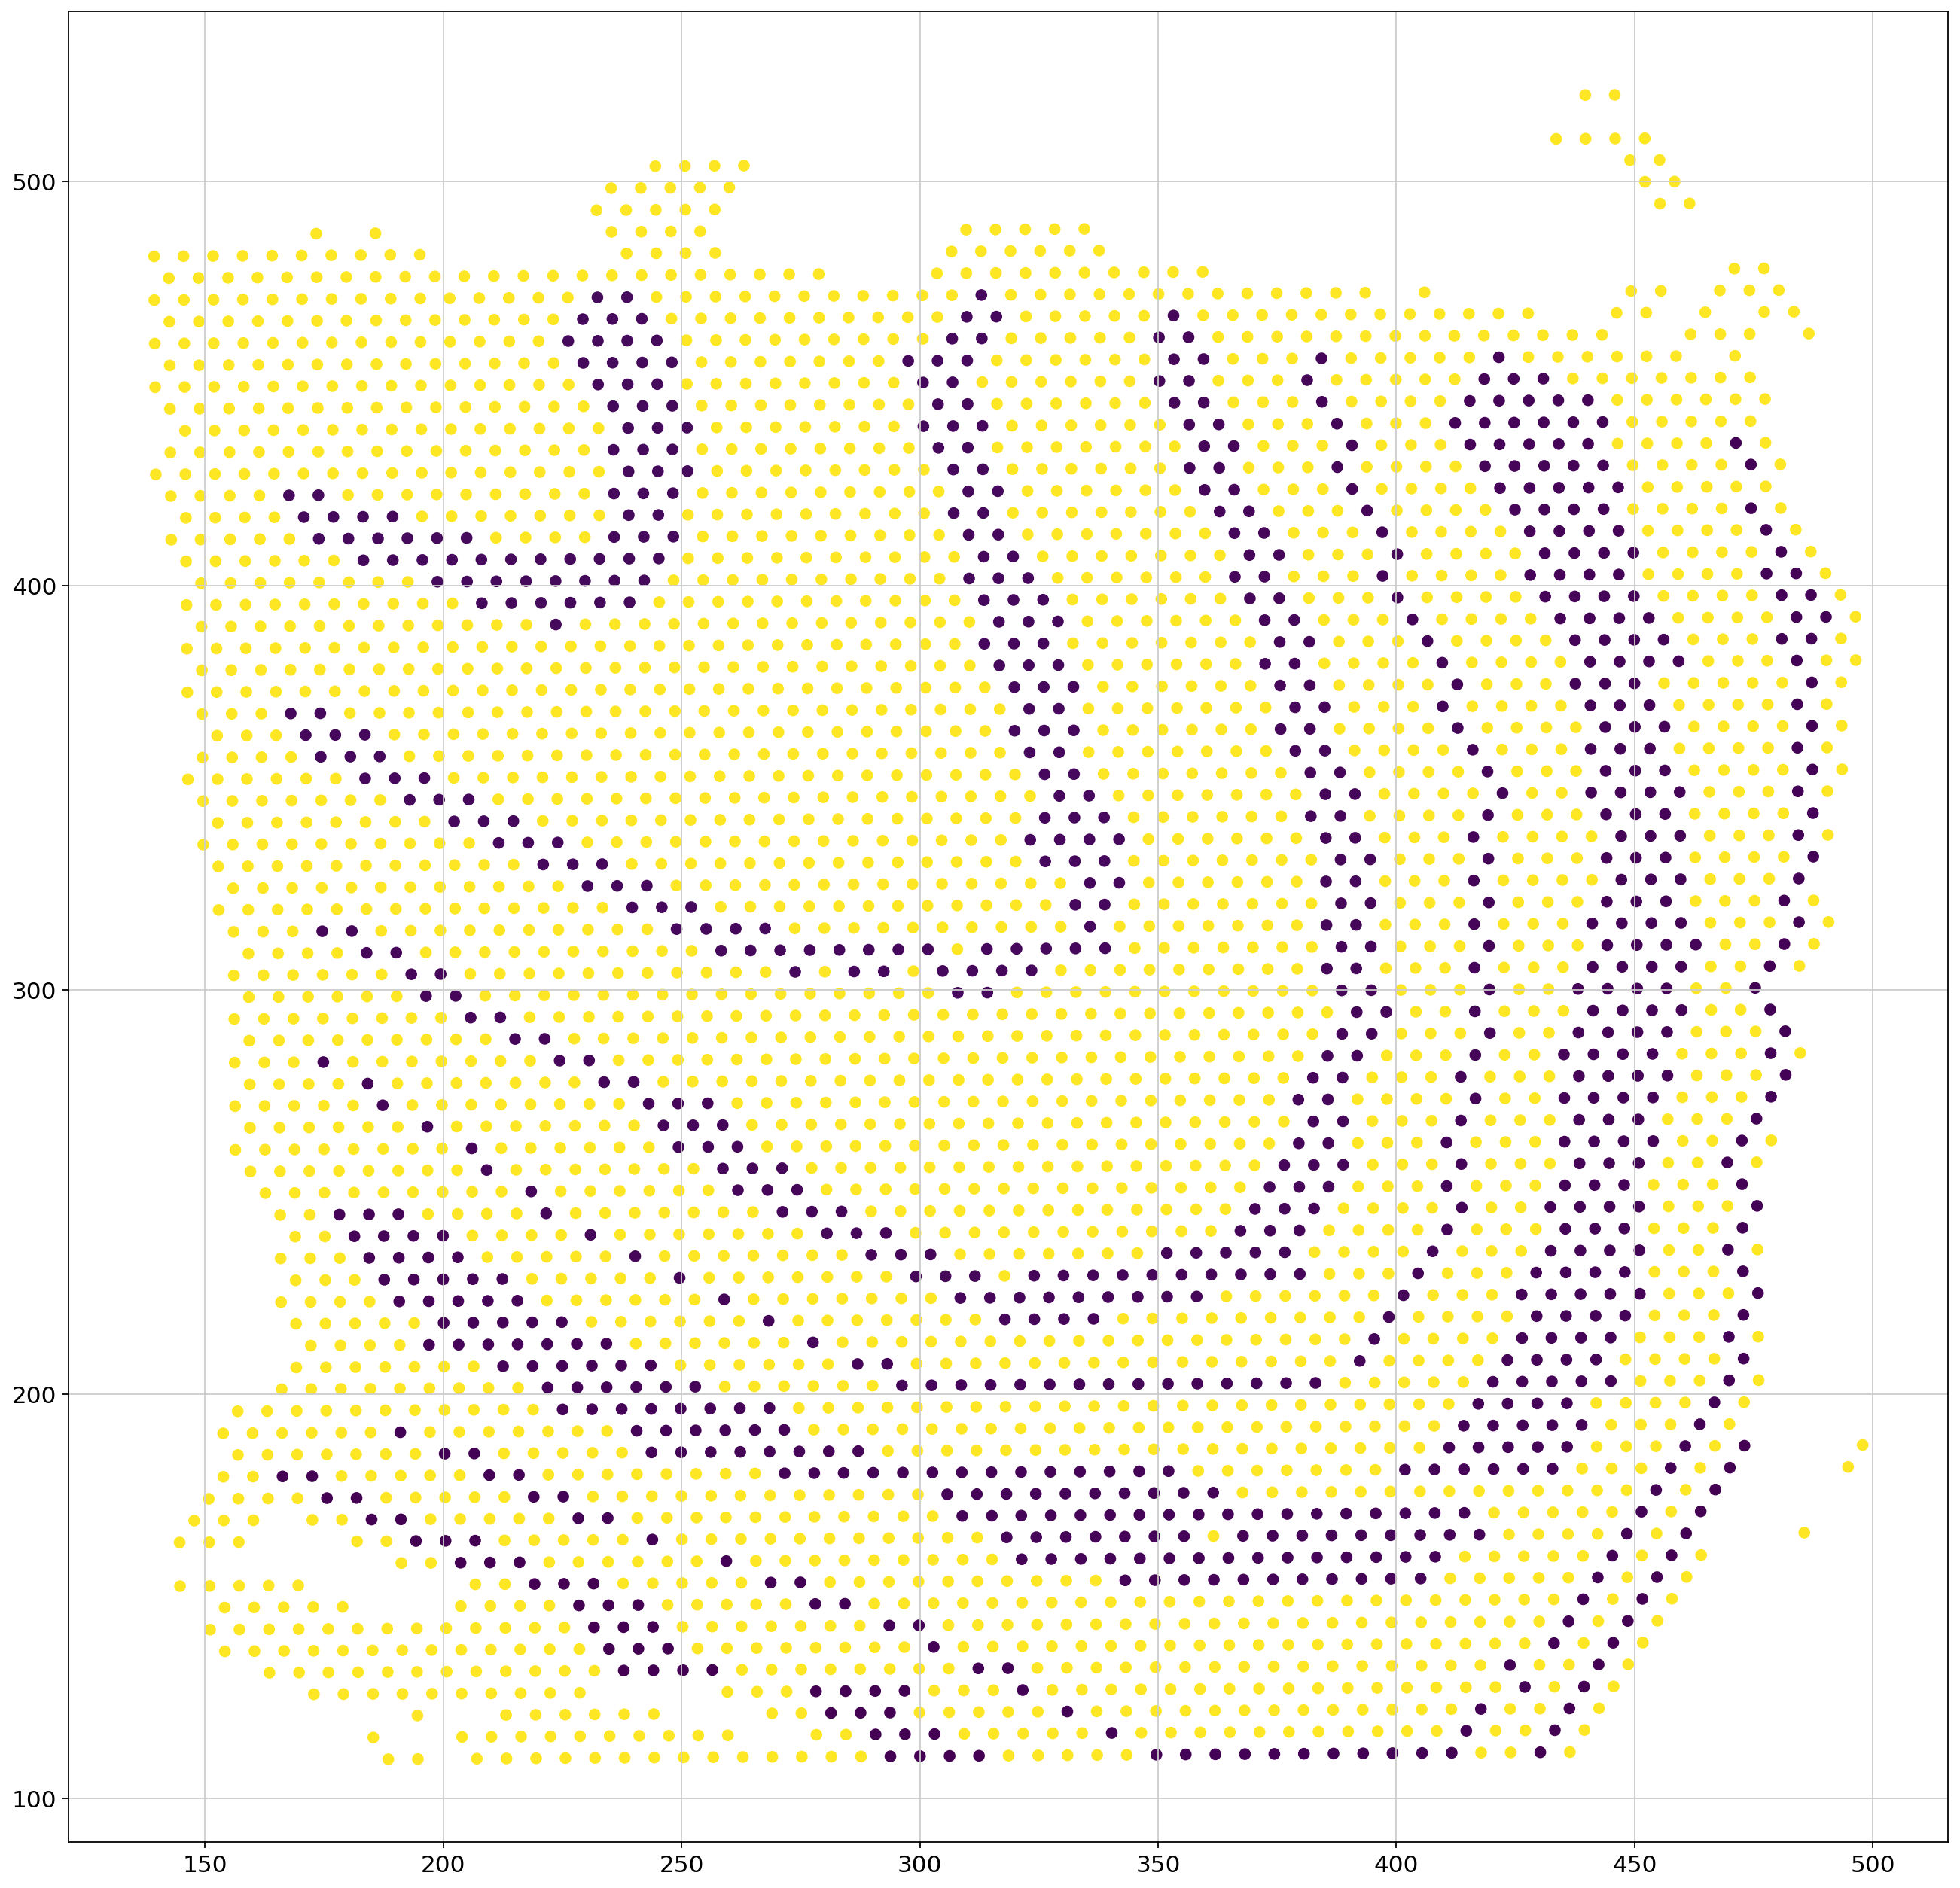

In [40]:
plt.scatter(y_cor, x_cor, c=scribble_labels)